# Test GEModelTools - HANC

**Table of contents**<a id='toc0_'></a>    
- 1. [Setup](#toc1_)    
- 2. [Step 1: Find Steady state](#toc2_)    
  - 2.1. [Idiosyncratic productivity](#toc2_1_)    
  - 2.2. [Policy functions](#toc2_2_)    
  - 2.3. [Simulation](#toc2_3_)    
- 3. [Tests](#toc3_)    
- 4. [Step 2: Compute Jacobians](#toc4_)    
- 5. [Step 3a: Find non-linear transition_path](#toc5_)    
- 6. [Step 3b: Find linearized IRFs](#toc6_)    
- 7. [Decompositions](#toc7_)    
  - 7.1. [Household behavior](#toc7_1_)    
  - 7.2. [Blocks](#toc7_2_)    
- 8. [Custom shocks](#toc8_)    
  - 8.1. [Path](#toc8_1_)    
  - 8.2. [Initial distribution](#toc8_2_)    
- 9. [Step 4. Simulation](#toc9_)    
- 10. [Changing unknowns, shocks and targets](#toc10_)    
- 11. [Example: Idiosyncratic risk and the steady state interest rate](#toc11_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

This notebook shows how to **solve a simple Heterogenous Agent Neo-Classical (HANC) model** using the `GEModelTools` package.

**The steps of the sequence-space solution method are:**

1. Find the stationary equilibrium (steady state for aggregates and distribution).
2. Compute Jacobians of the household block and the full model (to unknowns and shocks)
3. Find the non-linear transition path or the linearized impulse responses to a given shock path.
4. Simulate the linearized model with aggregate risk

In [14]:
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
from scipy import optimize

import matplotlib.pyplot as plt   
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.alpha":"0.25", "grid.linestyle": "--"})
plt.rcParams.update({'font.size': 14})

from HANCModel import HANCModelClass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. <a id='toc1_'></a>[Setup](#toc0_)

In [15]:
model = HANCModelClass(name='baseline') # create an instance of the model

Show **information**:

In [16]:
model.info()

settings:
 par.py_hh = False
 par.py_block = True
 par.full_z_trans = False
 par.T = 500

households:
 grids_hh: [a]
 pols_hh: [a]
 inputs_hh: [r,w0,w1]
 inputs_hh_z: []
 outputs_hh: [a,c,l0,l1]
 intertemps_hh: [vbeg_a]

aggregate:
 shocks: [Gamma]
 unknowns: [K,L0,L1]
 targets: [clearing_A,clearing_L0,clearing_L1]

blocks (inputs -> outputs):
 production_firm: [Gamma,K,L0,L1] -> [rK,w0,w1,Y]
 mutual_fund: [K,rK] -> [A,r]
 hh: [r,w0,w1] -> [A_hh,C_hh,L0_hh,L1_hh]
 market_clearing: [A,A_hh,L0,L1,L0_hh,L1_hh,Y,C_hh,K] -> [I,clearing_A,clearing_L0,clearing_L1,clearing_Y]


Show **DAG**:

production_firm: [Gamma,K,L0,L1] -> [rK,w0,w1,Y]
mutual_fund: [K,rK] -> [A,r]
hh: [r,w0,w1] -> [A_hh,C_hh,L0_hh,L1_hh]
market_clearing: [A,A_hh,L0,L1,L0_hh,L1_hh,Y,C_hh,K] -> [I,clearing_A,clearing_L0,clearing_L1,clearing_Y]


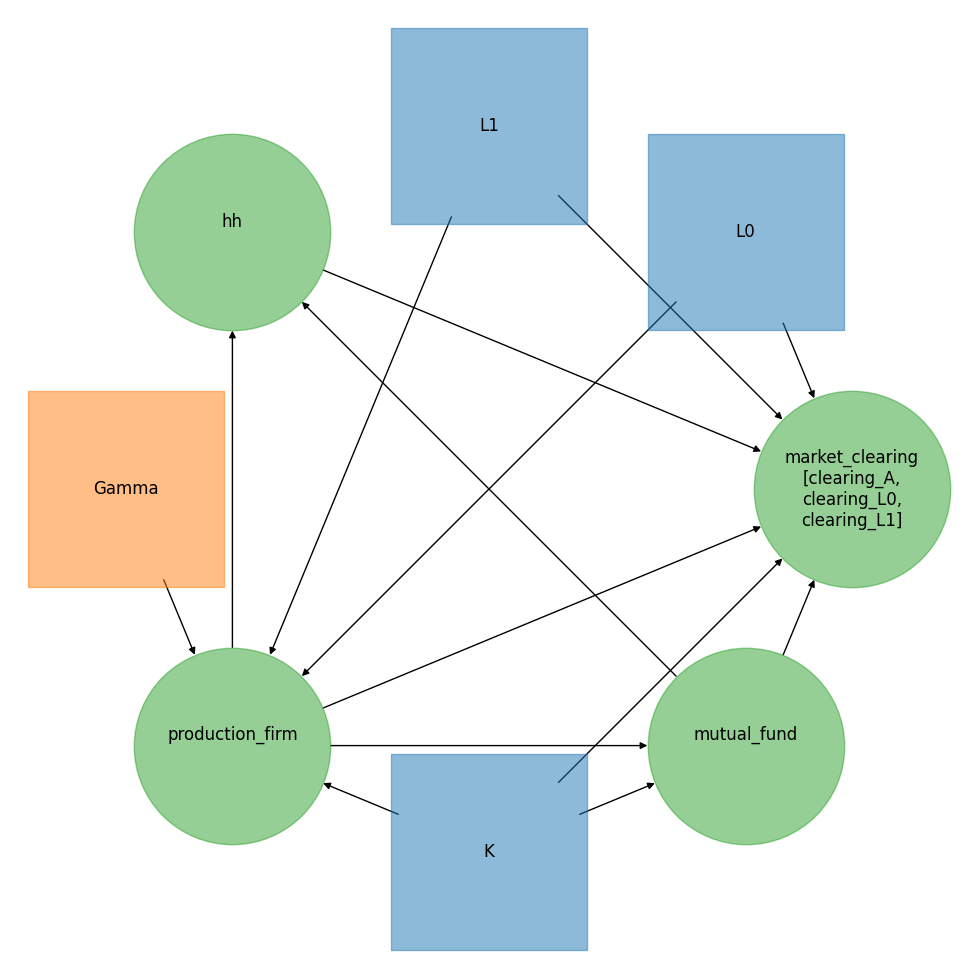

In [17]:
model.info(only_blocks=True)
model.draw_DAG(figsize=(10,10))

Detailed information:

In [18]:
print(model) # take a look inside

Modelclass: HANCModelClass
Name: baseline

namespaces: ['ini', 'par', 'path', 'sol', 'ss', 'sim']
other_attrs: ['grids_hh', 'pols_hh', 'inputs_hh', 'inputs_hh_z', 'outputs_hh', 'intertemps_hh', 'shocks', 'unknowns', 'targets', 'varlist', 'blocks', 'jac', 'H_U', 'H_Z', 'jac_hh', 'IRF']
savefolder: saved
cpp_filename: None

ini:
 Dbeg = ndarray with shape = (6, 7, 300) [dtype: float64]
 Gamma = nan [float]
 K = nan [float]
 L0 = nan [float]
 L1 = nan [float]
 rK = nan [float]
 w0 = nan [float]
 w1 = nan [float]
 Y = nan [float]
 A = nan [float]
 r = nan [float]
 A_hh = nan [float]
 C_hh = nan [float]
 L0_hh = nan [float]
 L1_hh = nan [float]
 I = nan [float]
 clearing_A = nan [float]
 clearing_L0 = nan [float]
 clearing_L1 = nan [float]
 clearing_Y = nan [float]
 memory, gb: 0.0

par:
 Nfix = 6 [int]
 Nbeta = 3 [int]
 Nz = 7 [int]
 sigma = 2.0 [float]
 beta_mean = 0.975 [float]
 beta_delta = 0.01 [float]
 phi_low = 1.0 [float]
 phi_high = 2.0 [float]
 chi_low = 0.0 [float]
 chi_low_prob 

In [19]:
model.find_ss(do_print=True,method='direct')

### step 1: broad search ###

guess ss.K = 1.0000
implied ss.r = nan
implied ss.w0 = 0.3200
implied ss.w1 = 0.3200
invalid value r = nan
clearing_A =          nan

guess ss.K = 2.0000
implied ss.r = nan
implied ss.w0 = 0.4107
implied ss.w1 = 0.4107
invalid value r = nan
clearing_A =          nan

guess ss.K = 3.0000
implied ss.r = nan
implied ss.w0 = 0.4752
implied ss.w1 = 0.4752
invalid value r = nan
clearing_A =          nan

guess ss.K = 4.0000
implied ss.r = nan
implied ss.w0 = 0.5271
implied ss.w1 = 0.5271
invalid value r = nan
clearing_A =          nan

guess ss.K = 5.0000
implied ss.r = nan
implied ss.w0 = 0.5712
implied ss.w1 = 0.5712
invalid value r = nan
clearing_A =          nan

guess ss.K = 6.0000
implied ss.r = nan
implied ss.w0 = 0.6099
implied ss.w1 = 0.6099
invalid value r = nan
clearing_A =          nan

guess ss.K = 7.0000
implied ss.r = nan
implied ss.w0 = 0.6447
implied ss.w1 = 0.6447
invalid value r = nan
clearing_A =          nan

guess ss.K = 8.0000
implied ss.r

ValueError: zero-size array to reduction operation minimum which has no identity

## 2. <a id='toc2_'></a>[Step 1: Find Steady state](#toc0_)

**Task:** We need to find

1. All variables in `.ss`
1. The steady state policy functions `ss.a` and `ss.c`
1. The steady state distributions `ss.Dbeg` and `ss.D`
1. The steady state aggregates `ss.A_hh` and `ss.C_hh`

In `.prepare_hh_ss()` [called in `.solve_hh_ss()` used in `.find_ss()`] we specify:

1. All grids in `.par` (can depend on steady state values prior to the household problem)
1. Initial guess for `ss.Dbeg` when iterating *forwards*
1. Initial guess for `ss.vbeg_a` when iterating *backwards*

In [ ]:
model.find_ss(do_print=True,method='direct')

### step 1: broad search ###

guess ss.K = 1.0000
implied ss.r = nan
implied ss.w0 = nan
implied ss.w1 = nan
invalid value r = nan
clearing_A =          nan

guess ss.K = 2.0000
implied ss.r = nan
implied ss.w0 = nan
implied ss.w1 = nan
invalid value r = nan
clearing_A =          nan

guess ss.K = 3.0000
implied ss.r = nan
implied ss.w0 = nan
implied ss.w1 = nan
invalid value r = nan
clearing_A =          nan

guess ss.K = 4.0000
implied ss.r = nan
implied ss.w0 = nan
implied ss.w1 = nan
invalid value r = nan
clearing_A =          nan

guess ss.K = 5.0000
implied ss.r = nan
implied ss.w0 = nan
implied ss.w1 = nan
invalid value r = nan
clearing_A =          nan

guess ss.K = 6.0000
implied ss.r = nan
implied ss.w0 = nan
implied ss.w1 = nan
invalid value r = nan
clearing_A =          nan

guess ss.K = 7.0000
implied ss.r = nan
implied ss.w0 = nan
implied ss.w1 = nan
invalid value r = nan
clearing_A =          nan

guess ss.K = 8.0000
implied ss.r = nan
implied ss.w0 = nan
implied ss.w1 =

ValueError: zero-size array to reduction operation minimum which has no identity

In [ ]:
model.info(only_blocks=True,ss=True)

production_firm: [Gamma=1.00,K=3.70,L0=1.00,L1=1.00] -> [rK=0.16,w0=1.00,w1=1.00,Y=1.60]
mutual_fund: [K=3.70,rK=0.16] -> [A=3.70,r=0.01]
hh: [r=0.01,w0=1.00,w1=1.00] -> [A_hh=3.70,C_hh=1.37,L0_hh=0.67,L1_hh=0.67]
market_clearing: [A=3.70,A_hh=3.70,L0=1.00,L1=1.00,L0_hh=0.67,L1_hh=0.67,Y=1.60,C_hh=1.37,K=3.70] -> [I=0.54,clearing_A=0.00,clearing_L0=0.33,clearing_L1=0.33,clearing_Y=-0.31]


**Unpack:** For easy access later on.

In [ ]:
par = model.par
ss = model.ss
path = model.path
sim = model.sim

**Solve and simumlate again:** Faster because the code has been numba-compiled.

In [ ]:
model.solve_hh_ss(do_print=True)
model.simulate_hh_ss(do_print=True)

household problem in ss solved in 0.9 secs [1290 iterations]
household problem in ss simulated in 0.3 secs [1406 iterations]


In [ ]:
model.test_path()

shocks: Gamma 
unknowns: K L0 L1 

blocks.production_firm
 rK               0.0e+00
 w0               4.9e-01
 w1               4.9e-01
 Y                0.0e+00
blocks.mutual_fund
 A                0.0e+00
 r                8.7e-18
hh
 A_hh             3.7e+00
 C_hh             6.7e-01
 L0_hh            6.2e-15
 L1_hh            5.8e-15
blocks.market_clearing
 I                    nan
 clearing_A       3.7e+00 [target]
 clearing_L0      3.3e-01 [target]
 clearing_L1      3.3e-01 [target]
 clearing_Y       6.7e-01


note: inputs = steady state value -> expected: constant value (straigt line)

household problem solved along transition path in 0.5 secs
household problem simulated along transition in 0.1 secs



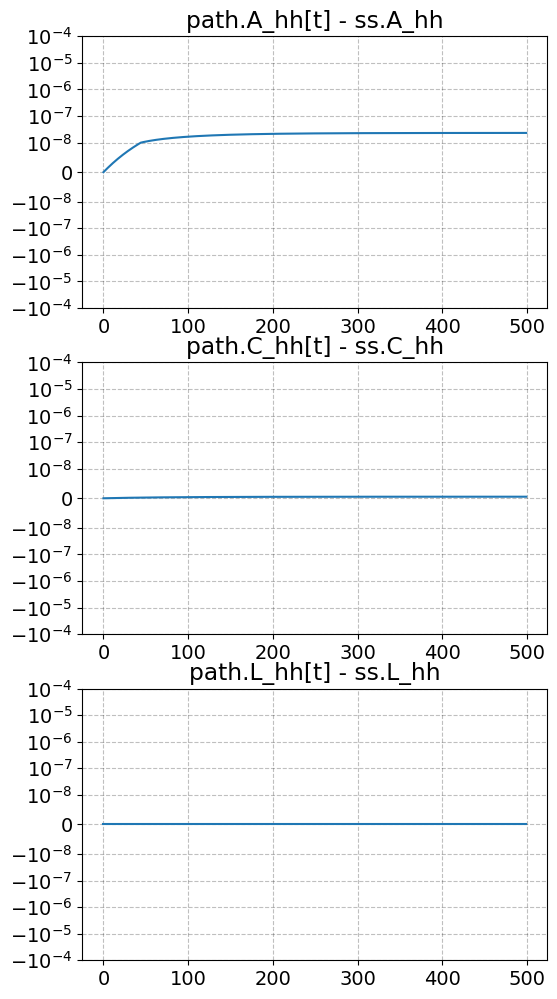

In [ ]:
model.test_hh_path()

### 2.1. <a id='toc2_1_'></a>[Idiosyncratic productivity](#toc0_)

**Productivity states:** A closer look at the productivity process.

In [ ]:
Dz = np.sum(ss.D,axis=2)
for i_fix in range(par.Nfix):
    
    beta = par.beta_grid[i_fix]
    print(f'{beta = :.2f}')
    for z,pr_z in zip(par.z_grid,Dz[i_fix]):
        print(f' Pr[z = {z:.4f}] = {pr_z:.4f}')

print('')

ss_mean_z = np.sum(par.z_grid*Dz)
ss_mean_log_z = np.sum(np.log(par.z_grid)*Dz)
print(f'mean(z): {ss_mean_z:.3f}')
assert np.isclose(ss_mean_z,1.0)

ss_std_z = np.sqrt(np.sum(Dz*(par.z_grid-ss_mean_z)**2))
print(f'std(z): {ss_std_z:.3f}')

ss_std_z = np.sqrt(np.sum(Dz*(np.log(par.z_grid)-ss_mean_log_z)**2))
print(f'std(log(z)): {ss_std_z:.3f}')

# note: the steady state transition matrix is in ss.z_trans

beta = 0.96
 Pr[z = 0.4585] = 0.0035
 Pr[z = 0.5858] = 0.0208
 Pr[z = 0.7484] = 0.0521
 Pr[z = 0.9561] = 0.0694
 Pr[z = 1.2215] = 0.0521
 Pr[z = 1.5605] = 0.0208
 Pr[z = 1.9936] = 0.0035
beta = 0.97
 Pr[z = 0.4585] = 0.0035
 Pr[z = 0.5858] = 0.0208
 Pr[z = 0.7484] = 0.0521
 Pr[z = 0.9561] = 0.0694
 Pr[z = 1.2215] = 0.0521
 Pr[z = 1.5605] = 0.0208
 Pr[z = 1.9936] = 0.0035
beta = 0.98
 Pr[z = 0.4585] = 0.0035
 Pr[z = 0.5858] = 0.0208
 Pr[z = 0.7484] = 0.0521
 Pr[z = 0.9561] = 0.0694
 Pr[z = 1.2215] = 0.0521
 Pr[z = 1.5605] = 0.0208
 Pr[z = 1.9936] = 0.0035
beta = 0.96
 Pr[z = 0.4585] = 0.0017
 Pr[z = 0.5858] = 0.0104
 Pr[z = 0.7484] = 0.0260
 Pr[z = 0.9561] = 0.0347
 Pr[z = 1.2215] = 0.0260
 Pr[z = 1.5605] = 0.0104
 Pr[z = 1.9936] = 0.0017
beta = 0.97
 Pr[z = 0.4585] = 0.0017
 Pr[z = 0.5858] = 0.0104
 Pr[z = 0.7484] = 0.0260
 Pr[z = 0.9561] = 0.0347
 Pr[z = 1.2215] = 0.0260
 Pr[z = 1.5605] = 0.0104
 Pr[z = 1.9936] = 0.0017
beta = 0.98
 Pr[z = 0.4585] = 0.0017
 Pr[z = 0.5858] = 0.0104
 Pr

**Grids:**

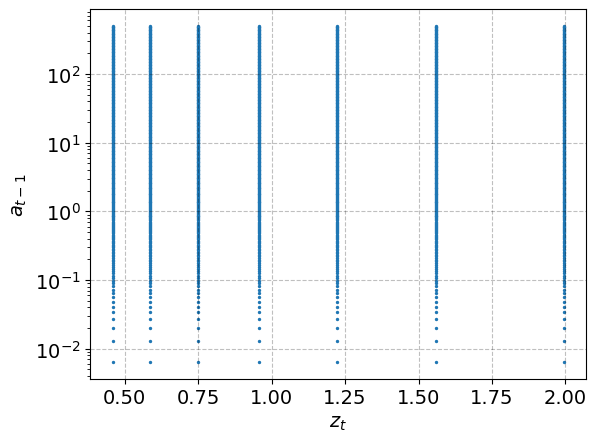

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

z_grid,a_grid = np.meshgrid(par.z_grid,par.a_grid,indexing='ij')
ax.scatter(z_grid,a_grid,2)

ax.set_yscale('log')
ax.set_xlabel('$z_t$')
ax.set_ylabel('$a_{t-1}$');

**Transition matrix for $z_t$:**

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.grid(False)
i_fix = 0
h = ax.matshow(ss.z_trans[i_fix],cmap='Pastel1')

for (i, j), value in np.ndenumerate(ss.z_trans[i_fix]):
    ax.text(j, i, f'{value:0.2f}', ha='center', va='center')
    
z_labels = [f'{z:.2f}' for z in par.z_grid]
xaxis = np.arange(par.z_grid.size)
ax.set_xticks(xaxis)
ax.set_xticklabels(z_labels) 
ax.set_yticks(xaxis)
ax.set_yticklabels(z_labels) 

ax.set_xlabel('$z_{t-1}$')
ax.set_ylabel('$z_{t}$');

**Ergodic distribution:**

In [ ]:
Dz = np.sum(ss.D,axis=2)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
i_fix = 0
ax.plot(par.z_grid,Dz[i_fix],'-o',label='pdf')
ax.axvline(np.sum(par.z_grid*Dz),color='black',label='mean')
ax.set_xlabel('$z_t$')
ax.set_ylabel('probability')
ax.legend(frameon=True);

### 2.2. <a id='toc2_2_'></a>[Policy functions](#toc0_)

The steady state policy functions are in `ss.a` and `ss.c`.

In [ ]:
for i_beta,beta in enumerate(par.beta_grid):
    
    fig = plt.figure(figsize=(12,4),dpi=100)

    I = par.a_grid < 500

    # a. consumption
    ax = fig.add_subplot(1,2,1)
    ax.set_title(f'consumption ($\\beta = {beta:.4f}$)')

    for i_z,z in enumerate(par.z_grid):
        if i_z%3 == 0 or i_z == par.Nz-1:
            ax.plot(par.a_grid[I],ss.c[i_beta,i_z,I],label=f'z = {z:.2f}')

    ax.legend(frameon=True)
    ax.set_xlabel('savings, $a_{t-1}$')
    ax.set_ylabel('consumption, $c_t$')
    ax.set_xlim(0,100)
    ax.set_ylim(0,4)

    # b. saving
    ax = fig.add_subplot(1,2,2)
    ax.set_title(f'saving ($\\beta = {beta:.4f}$)')

    for i_z,z in enumerate(par.z_grid):
        if i_z%3 == 0 or i_z == par.Nz-1:
            ax.plot(par.a_grid[I],ss.a[i_beta,i_z,I]-par.a_grid[I],label=f'z = {z:.2f}')

    ax.set_xlabel('savings, $a_{t-1}$')
    ax.set_ylabel('savings change, $a_{t}-a_{t-1}$')
    ax.set_xlim(0,100)
    ax.set_ylim(-3,1)

    fig.tight_layout()
    fig.savefig(f'figs/c_func_{i_beta}.pdf')

### 2.3. <a id='toc2_3_'></a>[Simulation](#toc0_)

The steady state distribution is in `ss.D` where `ss.D.shape == [par.Nbeta,par.Nz,par.Na]`

In [ ]:
fig = plt.figure(figsize=(12,4),dpi=100)

# a. income
ax = fig.add_subplot(1,2,1)
ax.set_title('productivity')
for i_beta,beta in enumerate(par.beta_grid):
    ax.plot(par.z_grid,np.cumsum(np.sum(ss.D[i_beta],axis=1))*par.Nfix,label=f'$\\beta = {beta:.4f}$')

ax.set_xlabel('productivity, $z_{t}$')
ax.set_ylabel('CDF')
ax.legend()

# b. assets
ax = fig.add_subplot(1,2,2)
ax.set_title('savings')
for i_beta in range(par.Nfix):
    ax.plot(np.insert(par.a_grid,0,par.a_grid[0]),np.insert(np.cumsum(np.sum(ss.D[i_beta],axis=0)),0,0.0)*par.Nfix,label=f'$\\beta = {par.beta_grid[i_beta]:.4f}$')
ax.set_xlabel('assets, $a_{t}$')
ax.set_ylabel('CDF')
ax.set_xscale('symlog')

fig.tight_layout()
fig.savefig('figs/distribution.pdf')

**Income moments:**

In [ ]:
mean_z = np.sum(ss.D*par.z_grid[:,np.newaxis])
std_z = np.sqrt(np.sum(ss.D*(par.z_grid[np.newaxis,:,np.newaxis]-mean_z)**2))
print(f'mean z: {mean_z:5.2f}')
print(f'std. z: {std_z:5.2f}')

**Asset moments:**

In [ ]:
# a. prepare
Da = np.sum(ss.D,axis=(0,1))
Da_cs = np.cumsum(Da)
mean_a = np.sum(Da*par.a_grid)
std_a = np.sqrt(np.sum(Da*(par.a_grid-mean_a)**2))

def percentile(par,Da_cs,p):
    
    # a. check first
    if p < Da_cs[0]: return par.a_grid[0]
    
    # b. find with loop
    i = 0
    while True:
        if p > Da_cs[i+1]:
            if i+1 >= par.Na: raise Exception()
            i += 1
            continue
        else:
            w = (p-Da_cs[i])/(Da_cs[i+1]-Da_cs[i])
            diff = par.a_grid[i+1]-par.a_grid[i]
            return par.a_grid[i]+w*diff
        
p25_a = percentile(par,Da_cs,0.25)
p50_a = percentile(par,Da_cs,0.50)
p95_a = percentile(par,Da_cs,0.95)
p99_a = percentile(par,Da_cs,0.99)

# b. print
print(f'mean a: {mean_a:6.3f}')
print(f'p25  a: {p25_a:6.3f}')
print(f'p50  a: {p50_a:6.3f}')
print(f'p95  a: {p95_a:6.3f}')
print(f'p99  a: {p99_a:6.3f}')
print(f'std. a: {std_a:6.3f}')

**MPC:**

In [ ]:
MPC = np.zeros(ss.D.shape)
dc = (ss.c[:,:,1:]-ss.c[:,:,:-1])
dm = (1+ss.r)*(par.a_grid[np.newaxis,np.newaxis,1:]-par.a_grid[np.newaxis,np.newaxis,:-1])
MPC[:,:,:-1] = dc/dm
MPC[:,:,-1] = MPC[:,:,-1] # assuming constant MPC at end
mean_MPC = np.sum(MPC*ss.D)
mean_MPC_ann = 1-(1-mean_MPC)**4
print(f'mean MPC: {mean_MPC:.3f} [annual: {mean_MPC_ann:.3f}]')

## 3. <a id='toc3_'></a>[Tests](#toc0_)

Here we run a couple of tests to show that the code behaves as expected. This is especially valuable when developing a new model.

**Household transition path:**

In [ ]:
model.test_hh_path()

**Full transition path:**

In [ ]:
model.test_path()

**Calculation of Jacobians:**

In [ ]:
model.test_jacs()

## 4. <a id='toc4_'></a>[Step 2: Compute Jacobians](#toc0_)

In [ ]:
model.compute_jacs(do_print=True) # if skip_shocks = True the full Jacobians to shocks are  not computed

The Jacobians are saved in:

1. **household Jacobians**: `model.jac_hh` is a dictionary with keys `(Outputname_hh,inputname)`
1. **full Jacobian to *unknowns***: `model.H_U` is a matrix
1. **full Jacobian to *shocks***: `model.H_Z` is a matrix
1. **full Jacobians**: `model.jac` is a dictionary with keys `(outputname,inputname)`

The **household Jacobians** are e.g. informative to look at.

In [ ]:
fig = plt.figure(figsize=(12,len(model.inputs_hh_all)*4),dpi=100)

i = 0
for varname in model.inputs_hh:
    
    # a. savings
    i += 1    
    ax = fig.add_subplot(len(model.inputs_hh_all),2,i)
    ax.set_title(f'savings, $a_t$, to {varname}')
    for s in [0,50,150,250]:
        jac_hh_var = model.jac_hh[('A_hh',varname)]
        ax.plot(np.arange(par.T),jac_hh_var[:,s],label=f'shock at {s}')
    
    if i == 1:
        ax.legend(frameon=True,bbox_to_anchor=(2.75,0.0))

    # b. consumption
    i += 1    
    ax = fig.add_subplot(len(model.inputs_hh_all),2,i)
    ax.set_title(f'consumption, $c_t$, to {varname}')
    for s in [0,50,150,250]:
        jac_hh_var = model.jac_hh[('C_hh',varname)]
        ax.plot(np.arange(par.T),jac_hh_var[:,s],label=f'shock at {s}')

## 5. <a id='toc5_'></a>[Step 3a: Find non-linear transition_path](#toc0_)

In [ ]:
model.find_transition_path(shocks=['Gamma'],do_print=True)

**Results:** We now have

1. The transition path of all variables, `path.VARNAME.shape == (par.T,1)`
1. The transition path of policy functions, `path.a` and `path.c`
1. The transition path of distributions, `path.D`

The **timing** is such that `path.A_hh[t] == np.sum(path.a[t]*path.D[t])`.

In [ ]:
diff = path.A_hh-np.sum(path.a*path.D,axis=(1,2,3))[:,np.newaxis]
max_abs_diff = np.max(np.abs(diff))
print(f'{max_abs_diff = }')

**Plot transitions**

In [ ]:
paths = ['Gamma','Y','K','r','rK','w']
abs_diff = ['r','rK']
facs = {'r':100,'rK':100}
model.show_IRFs(paths,abs_diff=abs_diff,facs=facs,ncols=3,T_max=100,filename='figs/technology_shock')

In [ ]:
i_beta = 1
i_z = par.Nz//2
beta = par.beta_grid[i_beta]
z = par.z_grid[i_z]

fig = plt.figure(figsize=(6,4),dpi=100)

I = par.a_grid < 500

# a. consumption
ax = fig.add_subplot(1,1,1)
ax.set_title(f'consumption ($\\beta = {beta:.4f}, z = {beta:.2f}$)')

ts = [0,10,20,40,80]
for t in ts:
    ax.plot(par.a_grid[I],path.c[t,i_beta,i_z,I],label=f'{t = }')

ax.legend(frameon=True)
ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('consumption, $c_t$')
ax.set_xlim(0,10)
ax.set_ylim(0.8,1.4)

fig.tight_layout()
fig.savefig('figs/c_func_path.pdf')

In [ ]:
for t in ts:

    fig = plt.figure(figsize=(6,4),dpi=100)

    ax = fig.add_subplot(1,1,1)
    ax.set_title('savings')    

    ax.plot(np.insert(par.a_grid,0,par.a_grid[0]),np.insert(np.cumsum(np.sum(path.D[0],axis=(0,1))),0,0.0),label=f't = 0',ls='--',color='black')
    
    if not t == 0:
        ax.plot(np.insert(par.a_grid,0,par.a_grid[0]),np.insert(np.cumsum(np.sum(path.D[t],axis=(0,1))),0,0.0),label=f't = {t}')

    ax.set_xlabel('assets, $a_{t}$')
    ax.set_ylabel('CDF')
    ax.set_xscale('symlog')
    ax.legend()
    fig.tight_layout()
    fig.savefig(f'figs/distribution_path_{t}.pdf')

## 6. <a id='toc6_'></a>[Step 3b: Find linearized IRFs](#toc0_)

In [ ]:
model.find_IRFs(shocks=['Gamma'],do_print=True,reuse_G_U=False)

**Results:** We now have `model.IRF[varname]` with the linear impulse response of all variables.

In [ ]:
model.show_IRFs(paths,abs_diff=abs_diff,facs=facs,ncols=3,T_max=100,do_linear=True)

## 7. <a id='toc7_'></a>[Decompose household behavior](#toc0_)

Find behavior when only some household inputs are active.

In [ ]:
T_max = 50

fig = plt.figure(figsize=(6,4),dpi=100)
ax = fig.add_subplot(1,1,1)
    
i_color = 0
for use_inputs in [['r'],['w'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(do_print=True,use_inputs=use_inputs)
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.A_hh[:50]/ss.A_hh-1)*100,ls=ls,color=color,label=label);

ax.set_ylabel('% diff to s.s.')
ax.legend(frameon=True,bbox_to_anchor=(1.01,0.99));

**Case 2:** Behavior for a subset of households. Here those with zero assets.

In [ ]:
T_max = 50

fig = plt.figure(figsize=(3*6,4),dpi=100)
    
Dbeg = ss.Dbeg.copy()
Dbeg[:,:,1:] = 0.0 # zero every else than in first asset grid point
Dbeg /= np.sum(Dbeg) # re-normalize

path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
path_alt = model.decompose_hh_path(Dbeg=Dbeg,use_inputs='all') 

ax = fig.add_subplot(1,3,1)
ax.set_title('response in ss')
ax.plot(path_alt_ss.A_hh[:T_max]);

ax = fig.add_subplot(1,3,2)
ax.set_title('response in path')
ax.plot(path_alt.A_hh[:T_max]);

ax = fig.add_subplot(1,3,3)
ax.set_title('difference')
ax.plot(path_alt.A_hh[:T_max]-path_alt_ss.A_hh[:T_max])

fig.tight_layout()

## 8. <a id='toc8_'></a>[Custom shocks](#toc0_)

### 8.1. <a id='toc8_1_'></a>[Path](#toc0_)

In [ ]:
# a. define shock
dGamma = np.zeros(par.T)
dGamma[12:24] = 0.01*ss.Gamma
shocks = {'dGamma':dGamma} # note the 'd' for difference (in absolute terms)

# b. find transition path
model.find_transition_path(do_print=True,shocks=shocks)

In [ ]:
model.show_IRFs(['Gamma','K'],T_max=100,do_shocks=False,do_targets=False,ncols=2,filename='figs/future_technology_shock')

### 8.2. <a id='toc8_2_'></a>[Initial distribution](#toc0_)

**Shock:** Assume everybody looses 5 percent of their wealth.

In [ ]:
K_shock = -0.05

**Adjust distribution:**

In [ ]:
ini = {}
ini['Dbeg'] = np.zeros(ss.Dbeg.shape)
for i_a_lag in range(par.Na):
    
    # a. assets after shock
    a_lag = par.a_grid[i_a_lag]
    a_lag_after = a_lag*(1+K_shock)
    
    # b. new grid point
    for i in range(par.Na-1):
        if not par.a_grid[i+1] <= a_lag_after: break
    
    # c. distribute mass
    w = (par.a_grid[i+1]-a_lag_after)/(par.a_grid[i+1]-par.a_grid[i])
    
    for i_fix in range(par.Nfix):
        ini['Dbeg'][i_fix,:,i] += w*ss.Dbeg[i_fix,:,i_a_lag]
        ini['Dbeg'][i_fix,:,i+1] += (1-w)*ss.Dbeg[i_fix,:,i_a_lag]    
    

**Calculate new capital stock:**

In [ ]:
ini_K = ini['K'] = np.sum(par.a_grid*ini['Dbeg'])
print(f'{ss.K  = :.3f}')
print(f'{ini_K = :.3f}')

**Find transition with no shocks:**

In [ ]:
model.find_transition_path(do_print=True,ini=ini,shocks=[]) 

In [ ]:
model.show_IRFs(['Gamma','K'],T_max=300,do_shocks=False,do_targets=False,ncols=2,filename='figs/initial_distribution')

## 9. <a id='toc9_'></a>[Step 4. Simulation](#toc0_)

In [ ]:
np.random.seed(1917)
model.simulate(do_print=True)

In [ ]:
def model_sim():
    
    fig = plt.figure(figsize=(12,8),dpi=100)

    ax = fig.add_subplot(2,2,1)
    ax.set_title('Gamma')
    ax.plot(ss.Gamma+sim.dGamma,ls='--')
    ax.axhline(ss.Gamma,color='black',zorder=0)

    ax = fig.add_subplot(2,2,2)
    ax.set_title('K')
    ax.plot(ss.K+sim.dK,ls='--',)
    ax.axhline(ss.K,color='black',zorder=0)

    ax = fig.add_subplot(2,2,3)
    ax.set_title('Compare K')
    ax.plot(ss.K+sim.dK,ls='-',label='linear');
    ax.plot(model.sim.A_hh_from_D,ls='--',label='from D')
    ax.legend(frameon=True)

    ax = fig.add_subplot(2,2,4)
    ax.set_title('... difference')
    ax.plot(model.sim.A_hh_from_D-(ss.K+sim.dK))

    fig.tight_layout()

In [ ]:
model_sim()

## 10. <a id='toc10_'></a>[Changing unknowns, shocks and targets](#toc0_)

We can update the **update aggregate settings** and automatically reallocate everything, where we consider $L$ as a shock:

In [ ]:
model.find_transition_path(shocks=['Gamma'])

In [ ]:
model_ = model.copy()
model_.update_aggregate_settings(unknowns=['K'],shocks=['Gamma','L'],targets=['clearing_A'])


We get the exact same results:

In [ ]:
model_.compute_jacs()
model_.find_transition_path(shocks=['Gamma'])
model.compare_IRFs([model,model_],['old','new'],varnames=['K'],do_shocks=False,do_targets=False)

## 11. <a id='toc11_'></a>[Example: Idiosyncratic risk and the steady state interest rate](#toc0_)

In [ ]:
print(f'ss.A_hh = ss.K = {ss.A_hh:.2f}')
print(f'ss.r = {ss.r*100:.2f} %')
print('')
      
for sigma_psi in np.linspace(par.sigma_psi,2*par.sigma_psi,5):
    
    print(f'{sigma_psi = :.2f}')

    model_ = model.copy()
    model_.par.sigma_psi = sigma_psi
        
    model_.solve_hh_ss(do_print=False)
    model_.simulate_hh_ss(do_print=False)
    
    A_hh = np.sum(model_.ss.a*model_.ss.D)
    
    print(f'PE {A_hh = :.2f}')
          
    model_.find_ss(method='direct')

    print(f'GE ss.r = {model_.ss.r*100:.2f} %')
    print(f'GE ss.A_hh = ss.K = {model_.ss.A_hh:.2f}')

    print('')